### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут:
1) $ 2(y_i - a_{t-1}(x_i))$


2) $ y_i exp( -a_{t-1}(x_i) y_i) $


3) $ \frac{y_i exp( -a_{t-1}(x_i) y_i)} {\log (1 + exp( -a_{t-1}(x_i) y_i))}   $

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import random
from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [42]:
from sklearn.base import BaseEstimator, ClassifierMixin
class MyGradientBoostingClassifier():

    def __init__(self, loss = 'MSE', learning_rate = 0.1, n_estimators = 5, colsample = 40, subsample = 50, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        self.models = []
        self.features = []
        self.init = 0
        self.init_model = None
    
    def fit(self, X, y, base_model, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        # Ваш код здесь
        if init_model is None:
            self.init = y.mean()
            f = [self.init] * y.shape[0]
            f =  np.array(f)
        else:
            clf = init_model(*self.args, **self.kwargs)
            clf.fit(X,y)
            self.models.append(clf)
            self.features.append(list(range(X.shape[1])))
            f = np.array(clf.predict(X))
            self.init_model = clf

        for n in range(self.n_estimators):
            num_of_features = list(range(X.shape[1]))
            random.shuffle(num_of_features)
            count_of_features = round(X.shape[1] * self.colsample / 100)
            num_of_features = num_of_features[:count_of_features]
            Xfeatures = X[:, num_of_features]
            self.features.append(num_of_features)
            
            num_of_objects = list(range(X.shape[0]))
            random.shuffle(num_of_objects)
            count_of_objects = round(X.shape[0] * self.subsample / 100)
            num_of_objects = num_of_objects[:count_of_objects]
            X_subsample = Xfeatures[num_of_objects,:]
            y_subsample = y[num_of_objects]
            f_subsample = f[num_of_objects]
            
            if self.loss == 'MSE':
                target = 2 * (y_subsample - f_subsample)
            if self.loss == 'exp':
                target =  y_subsample * np.exp(- y_subsample * f_subsample)
            if self.loss == 'log':
                target = y_subsample * np.exp(- y_subsample * f_subsample) / (1 + np.exp(- y_subsample * f_subsample))
                
            clf = base_model(*self.args, **self.kwargs)
            clf.fit(X_subsample, target)
            self.models.append(clf)
            f = f + self.learning_rate * np.array(clf.predict(Xfeatures))
        
    def predict(self, X):
        # Ваш код здесь
        if self.init != 0:
            pred = np.array([self.init] * X.shape[0])
        else:
            pred = np.array(self.init_model.predict(X)).astype(float)
        for n in range(self.n_estimators):
            pred += self.learning_rate * self.models[n].predict(X[:, self.features[n]])
        return  np.round(pred)



In [8]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [9]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [10]:
my_clf.fit(X_train, y_train, base_model = DecisionTreeRegressor)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8888888888888888
0.8888888888888888


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [11]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [12]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [17]:
num_of_iter = [2, 5, 7, 10, 15, 20]
accuracy = []
for n in num_of_iter:
    my_clf = MyGradientBoostingClassifier(n_estimators = n)
    my_clf.fit(X_train, y_train, base_model = DecisionTreeRegressor)
    accuracy.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

Text(0.5, 1.0, 'Зависимость точности от числа итераций')

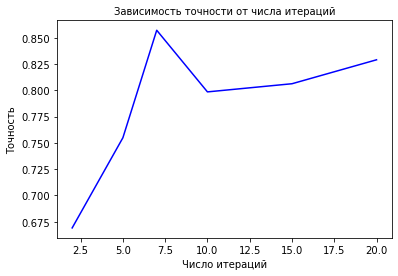

In [18]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(1,1,figsize = (6,4))
plt.plot(num_of_iter, accuracy, color='b')
axes.set_xlabel(u'Число итераций',fontsize = 10)
axes.set_ylabel(u'Точность',fontsize = 10)
axes.set_title(u'Зависимость точности от числа итераций',fontsize = 10)


Слегка редактируем исходный классификатор, чтобы положить в GridSearchCV

In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin
class MyGradientBoostingClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, loss = 'MSE', learning_rate = 0.1, n_estimators = 5, colsample = 40, subsample = 50):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        #self.args = args
        #self.kwargs = kwargs
        self.models = []
        self.features = []
        self.init = 0
        
    
    def fit(self, X, y, base_model, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        # Ваш код здесь
        if init_model is None:
            self.init = y.mean()
            f = [self.init] * y.shape[0]
            f =  np.array(f)
        else:
            clf = init_model()
            clf.fit(X,y)
            self.models.append(clf)
            self.features.append(list(range(X.shape[1])))
            f = np.array(clf.predict(X))

        for n in range(self.n_estimators):
            num_of_features = list(range(X.shape[1]))
            random.shuffle(num_of_features)
            count_of_features = round(X.shape[1] * self.colsample / 100)
            num_of_features = num_of_features[:count_of_features]
            Xfeatures = X[:, num_of_features]
            self.features.append(num_of_features)
            
            num_of_objects = list(range(X.shape[0]))
            random.shuffle(num_of_objects)
            count_of_objects = round(X.shape[0] * self.subsample / 100)
            num_of_objects = num_of_objects[:count_of_objects]
            X_subsample = Xfeatures[num_of_objects,:]
            y_subsample = y[num_of_objects]
            f_subsample = f[num_of_objects]
            
            if self.loss == 'MSE':
                target = 2 * (y_subsample - f_subsample)
            if self.loss == 'exp':
                target =  y_subsample * np.exp(- y_subsample * f_subsample)
            if self.loss == 'log':
                target = y_subsample * np.exp(- y_subsample * f_subsample) / (1 + np.exp(- y_subsample * f_subsample))
                
            clf = base_model()
            clf.fit(X_subsample, target)
            self.models.append(clf)
            f = f + self.learning_rate * np.array(clf.predict(Xfeatures))
        
    def predict(self, X):
        # Ваш код здесь
        pred = np.array([self.init] * X.shape[0])
        for n in range(self.n_estimators):
            pred += self.learning_rate * self.models[n].predict(X[:, self.features[n]])
        return  np.round(pred)




In [21]:
from sklearn.model_selection import GridSearchCV
loss = ['MSE', 'exp', 'log']
learning_rate = [0.05, 0.1, 0.15, 0.2]
colsample = [30, 40, 50, 60]
subsample = [30, 40, 50, 60]
clf = MyGradientBoostingClassifier(n_estimators = 7)
searcher = GridSearchCV(clf, param_grid = {'loss': loss,'learning_rate': learning_rate, 'colsample': colsample, 'subsample': subsample},
                        scoring='accuracy')

searcher.fit(X_train, y_train, base_model = DecisionTreeRegressor)

GridSearchCV(estimator=MyGradientBoostingClassifier(n_estimators=7),
             param_grid={'colsample': [30, 40, 50, 60],
                         'learning_rate': [0.05, 0.1, 0.15, 0.2],
                         'loss': ['MSE', 'exp', 'log'],
                         'subsample': [30, 40, 50, 60]},
             scoring='accuracy')

In [22]:
searcher.best_params_

{'colsample': 60, 'learning_rate': 0.05, 'loss': 'log', 'subsample': 50}

In [23]:
searcher.best_score_

0.8658475299421802

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [43]:
from sklearn.ensemble import RandomForestRegressor

In [46]:
my_clf = MyGradientBoostingClassifier(loss = 'log', colsample = 60, subsample= 50, learning_rate = 0.05, n_estimators = 7)
my_clf.fit(X_train, y_train, base_model = RandomForestRegressor)

In [47]:
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.872093023255814


1) Качество улучшилось, что видно даже без подборка по сетке. Случайный лес дает усложение модели.


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [56]:
pred = np.ones([X_test.shape[0]]) * y_train.mean()
for n in range(20):
    num_of_objects = list(range(X_train.shape[0]))
    random.shuffle(num_of_objects)
    count_of_objects = round(X.shape[0] * 50 / 100)
    num_of_objects = num_of_objects[:count_of_objects]
    X_subsample = X_train[num_of_objects,:]
    y_subsample = y_train[num_of_objects]
    my_clf = MyGradientBoostingClassifier(loss = 'log', colsample = 60, subsample= 50, learning_rate = 0.05, n_estimators = 7)
    my_clf.fit(X_subsample, y_subsample, DecisionTreeRegressor)
    pred += my_clf.predict(X_test)
pred = np.round(pred / 20)
print(accuracy_score(y_pred=pred, y_true=y_test))

0.8837209302325582


2) Аналогично качество улучшается. Так как модель усложняется. 

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [57]:
from sklearn import linear_model
from sklearn.svm import SVC

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## Logistic model

In [66]:
my_clf = MyGradientBoostingClassifier(loss = 'log', colsample = 60, subsample= 50, learning_rate = 0.05, n_estimators = 7)
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model=linear_model.LogisticRegression)
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8091085271317829


## RandomForestRegressor

In [64]:
my_clf = MyGradientBoostingClassifier(loss = 'log', colsample = 60, subsample= 50, learning_rate = 0.05, n_estimators = 7)
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model=RandomForestRegressor)
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8798449612403101


## SVM

In [67]:
my_clf = MyGradientBoostingClassifier(loss = 'log', colsample = 60, subsample= 50, learning_rate = 0.05, n_estimators = 7)
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model=SVC)
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.5876937984496124


Качество улучшается, но не на всех моделях. Возможно для улучшения нужно подбирать параметры для инициализирующей модели на валидации. 

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

